In [12]:
import os
import pandas as pd
import numpy as np
import six
import xarray as xr
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from matplotlib import dates
from shapely import geometry

from stompy import utils,memoize
from stompy import filters
from stompy.io.local import noaa_coops
from stompy.model.suntans import sun_driver
from stompy import xr_utils
from stompy.grid import unstructured_grid
from stompy.plot import plot_utils
from stompy.spatial import field, proj_utils 
from stompy.model import data_comparison
%matplotlib notebook

In [3]:
cache_dir="cache"
os.path.exists(cache_dir) or os.makedirs(cache_dir)
fig_dir="figs-20190709"
os.path.exists(fig_dir) or os.makedirs(fig_dir)

True

In [4]:
six.moves.reload_module(sun_driver)
model=sun_driver.SuntansModel.load("/opt2/sfb_ocean/suntans/runs/merge_015-201707/")

INFO:DFlowModel:Will read cell depths, too


In [ ]:
plt.figure()
model.grid.plot_edges(color='k',lw=0.5)

In [ ]:
plt.figure(1).gca().axis()

In [5]:
avg=xr.open_dataset(model.avg_outputs()[0])
g=unstructured_grid.UnstructuredGrid.from_ugrid(avg)

San Jose
==


In [6]:
@memoize.memoize(lru=100)
def extract_section(section,g=g,avg=avg,extra_vars=[]):
    nodes=[g.select_nodes_nearest(x) for x in section]
    path=[nodes[0]]
    for na,nb in zip(nodes[:-1],nodes[1:]):
        full_nodes=g.shortest_path(na,nb)
        path.extend(full_nodes[1:])

    hes=[g.nodes_to_halfedge(na,nb)
         for na,nb in zip(path[:-1],path[1:])]
    edges=[he.j for he in hes]
    edge_signs=np.array([(-1)**(he.orient) for he in hes])
    times=[]
    Qs=[]

    for ti in utils.progress(range(len(avg.time))):
        times.append(avg.time.values[ti])
        #U_F=avg.U_F.isel(time=ti).isel(Ne=edges).sum(dim='Nk')
        # U_F ~ [time,Nk,Ne]
        # the above seems to scale poorly with edges
        U_F=np.nansum(avg.U_F.isel(time=ti).values[:,edges],axis=0)
        Qs.append( (U_F*edge_signs).sum() )
        
    ds=xr.Dataset()
    ds['time']=('time',),times
    ds['Q']=('time',),Qs
    ds['x']=('node',),g.nodes['x'][path,0]
    ds['y']=('node',),g.nodes['x'][path,1]    
    
    vals={}
    for v in extra_vars:
        vals[v]=[]
        
    for ti in utils.progress(range(len(avg.time))):
        for v in extra_vars:
            #v_F=avg[v].isel(time=ti).isel(Ne=edges).sum(dim='Nk')
            v_F=np.nansum(avg[v].isel(time=ti).values[:,edges],axis=0)
            vals[v].append( (v_F*edge_signs).sum() )
    for v in extra_vars:
        ds[v]=('time',),vals[v]
    
    return ds

In [7]:
def plot_section(zoom,section,label='Flow'):
    sec=extract_section(section)
    fig,axs=plt.subplots(1,2,figsize=(9,4.5))
    g.plot_edges(color='k',lw=0.5,ax=axs[0])
    #g.plot_edges(color='r',lw=1,mask=edges,ax=axs[0])
    axs[0].plot(sec.x,sec.y,lw=1,color='r')
    axs[0].axis(zoom)
    axs[1].plot(sec.time,sec.Q,label=label)
    dnum=utils.to_dnum(sec.time.values)
    Qlp=filters.lowpass(sec.Q.values,dnum,cutoff=4)
    axs[1].plot(sec.time,Qlp,label='Lowpass')
    axs[1].legend()
    

<IPython.core.display.Javascript object>


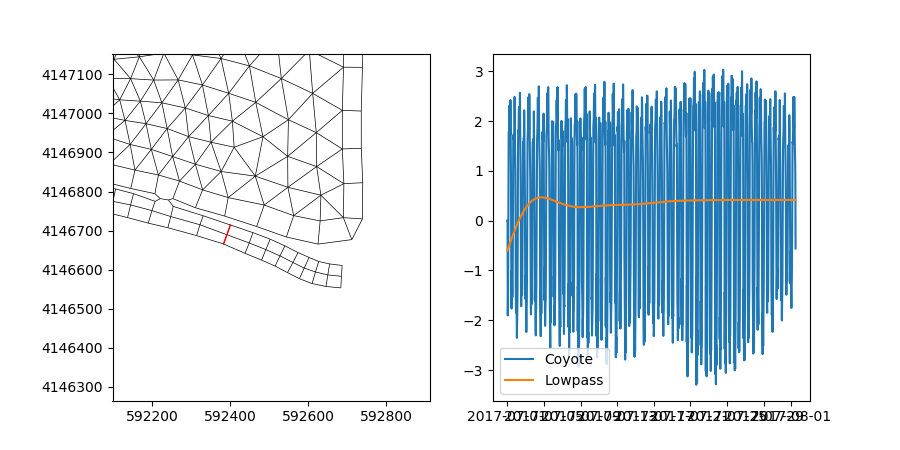

In [10]:
section=np.array([[592384,4.14666e6],
                  [592401,4.14671e6]])
zoom=(592099., 592911., 4146406., 4147011.)
plot_section(zoom,section,label='Coyote')

In [ ]:
section=np.array([ [591482,4.14144e6],
                   [591561,4.14150e6]])
zoom=(590808.5810001208, 591872.5177298876, 4141005.5616101287, 4142168.3414941444)
plot_section(zoom,section,label='Guad River')

In [ ]:
zoom=(590414., 592844., 4144893., 4146703.)
# river left to right:
section=np.array([[591640,4.14644e6],
                  [591681,4.14643e6]])

plot_section(zoom,section,label='San Jose')

In [ ]:
zoom=(588403., 589098., 4141502., 4142261.)
# river left to right:
section=np.array([[588916,4.141698e6],
                  [588939,4.141700e6]])

plot_section(zoom,section,label='Guad Slough')

In [ ]:
section=np.array( [[577077,4.15062e6],
                   [578667,4.15133e6]])
zoom=(574473., 579596., 4149397., 4154991.)
plot_section(zoom,section,label='Dumbarton')
# This looks pretty reasonable - maybe 10 m3/s

In [ ]:
avg.s_F.isel(time=10).max()

In [ ]:
np.mean(Qs) # 4.56 m3/s -- pretty realistic.


In [ ]:
section=np.array( [[577077,4.15062e6],
                   [578667,4.15133e6]])
sec=extract_section(section,extra_vars=['s_F'])

In [ ]:
plt.figure()
plt.plot(sec.time,sec.s_F)
plt.plot(sec.time, 
         filters.lowpass(sec.s_F.values,utils.to_dnum(sec.time.values),
                                       cutoff=4))

win=np.hanning(len(sec.time))
win=win/win.sum()

print((win*sec.s_F.values).sum(), 
      (win*sec.Q.values).sum())

<IPython.core.display.Javascript object>


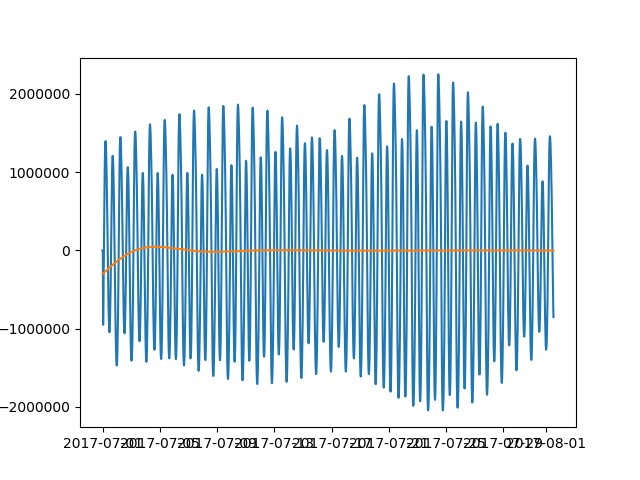

salt flux total: -1822.9967782660092   Q total: 14.536028161880765


<IPython.core.display.Javascript object>


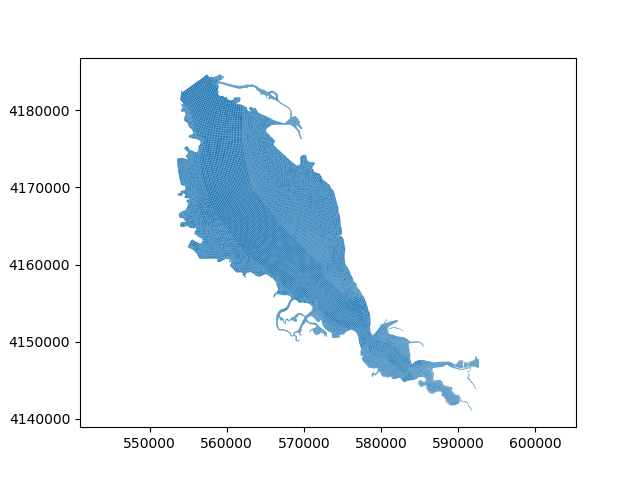

salt loss over 30 days: -1.4914688591738736 per volume -9.42169368074019 per area
Region volume: 3.1682e+09 m3   area: 5.0152e+08 m2


In [88]:
# all of South Bay
section=np.array( [[553960,4.182766e6],
                   [557945,4.184386e6]])
sec=extract_section(section,extra_vars=['s_F'])

plt.figure()
plt.plot(sec.time,sec.s_F)
plt.plot(sec.time, 
         filters.lowpass(sec.s_F.values,utils.to_dnum(sec.time.values),
                                       cutoff=4))

win=np.hanning(len(sec.time))
win=win/win.sum()

s_F_total=(win*sec.s_F.values).sum()
Q_total=(win*sec.Q.values).sum()
print(f"salt flux total: {s_F_total}   Q total: {Q_total}")

sel_cells=section_to_cells( np.c_[sec.x.values,sec.y.values] )

plt.figure()
g.plot_cells(mask=sel_cells)
plt.axis('equal')

Ac=avg.Ac.values[sel_cells]
dv=avg.dv.values[sel_cells]
eta=avg.eta.isel(time=10).values[sel_cells]
V=((dv+eta)*Ac).sum()
A=Ac.sum()

salt_flux_int=s_F_total * 86400 * 30
print(f"salt loss over 30 days: {salt_flux_int/V} per volume {salt_flux_int/A} per area")

# need to account for change in storage, too.
print(f"Region volume: {V:.4e} m3   area: {A:.4e} m2")



In [ ]:
from shapely import geometry
polyline=geometry.LineString(np.c_[sec.x.values,sec.y.values])

lsb_cells=g.select_cells_by_cut(polyline,side='right')

In [ ]:
plt.figure()
g.plot_cells(mask=lsb_cells)
plt.axis('equal')

In [ ]:
Ac=avg.Ac.values[lsb_cells]
dv=avg.dv.values[lsb_cells]
eta=avg.eta.isel(time=10).values[lsb_cells]
V=((dv+eta)*Ac).sum()
A=Ac.sum()

In [ ]:
# mean salt flux was -38 
# that's ppt * m3/s
# so kg/s
# if the residence time of LSB, including the ponds that are in the model
# is 10 days, total salt mass lost is
salt_flux_int=-1800 * 86400 * 30
salt_flux_int/V

<IPython.core.display.Javascript object>


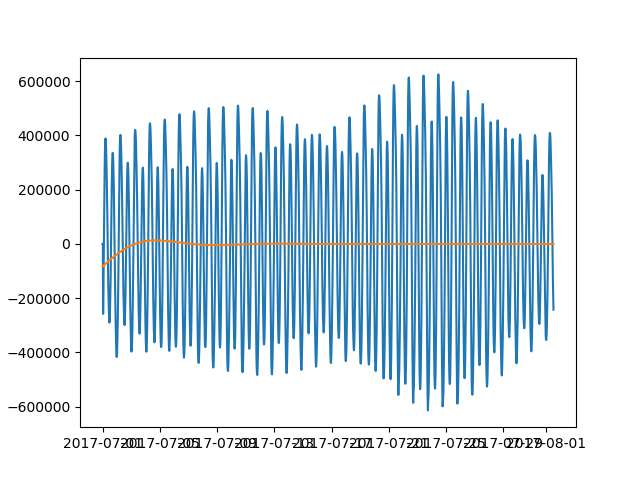

salt flux total: -284.2181775740721   Q total: 2.4913474854470365


INFO:UnstructuredGrid:checked on 5000/105864 edges
INFO:UnstructuredGrid:checked on 10000/105864 edges
INFO:UnstructuredGrid:checked on 15000/105864 edges
INFO:UnstructuredGrid:checked on 20000/105864 edges
INFO:UnstructuredGrid:checked on 25000/105864 edges
INFO:UnstructuredGrid:checked on 30000/105864 edges
INFO:UnstructuredGrid:checked on 35000/105864 edges
INFO:UnstructuredGrid:checked on 40000/105864 edges
INFO:UnstructuredGrid:checked on 45000/105864 edges
INFO:UnstructuredGrid:checked on 50000/105864 edges
INFO:UnstructuredGrid:checked on 55000/105864 edges
INFO:UnstructuredGrid:checked on 60000/105864 edges
INFO:UnstructuredGrid:checked on 65000/105864 edges
INFO:UnstructuredGrid:checked on 70000/105864 edges
INFO:UnstructuredGrid:checked on 75000/105864 edges
INFO:UnstructuredGrid:checked on 80000/105864 edges
INFO:UnstructuredGrid:checked on 85000/105864 edges


salt loss over 30 days: -1.196095509138075


In [15]:
# Just the SB shoals
section=np.array([
       [ 576487.87684616, 4158604.94120622],
       [ 573181.9907784 , 4157585.04018531],
       [ 567027.41565224, 4163036.23529705],
       [ 562877.47356718, 4169366.65542681],
       [ 561224.5305333 , 4176048.76556378],
       [ 565304.13461692, 4177596.20159549] ])

sec=extract_section(section,extra_vars=['s_F'])

plt.figure()
plt.plot(sec.time,sec.s_F)
plt.plot(sec.time, 
         filters.lowpass(sec.s_F.values,utils.to_dnum(sec.time.values),
                                       cutoff=4))
win=np.hanning(len(sec.time))
win=win/win.sum()

s_F_total=(win*sec.s_F.values).sum()
Q_total=(win*sec.Q.values).sum()
print(f"salt flux total: {s_F_total}   Q total: {Q_total}")

polyline=geometry.LineString(np.c_[sec.x.values,sec.y.values])
sel_cells=g.select_cells_by_cut(polyline,side='right')
Ac=avg.Ac.values[sel_cells]
dv=avg.dv.values[sel_cells]
eta=avg.eta.isel(time=10).values[sel_cells]
V=((dv+eta)*Ac).sum()
A=Ac.sum()

salt_flux_int=s_F_total * 86400 * 30
print(f"salt loss over 30 days: {salt_flux_int/V}")



In [19]:
@memoize.memoize()
def section_to_cells(xy):
    polyline=geometry.LineString(xy)
    return g.select_cells_by_cut(polyline,side='right')


<IPython.core.display.Javascript object>


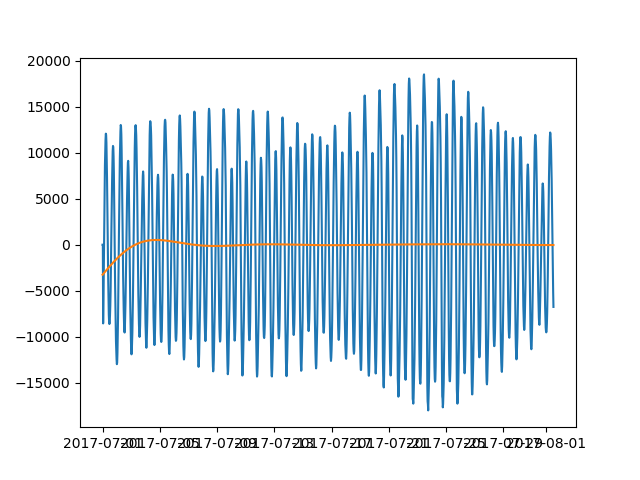

salt flux total: -3.8570826470146535   Q total: 0.1965592258357775


INFO:UnstructuredGrid:checked on 5000/105864 edges
INFO:UnstructuredGrid:checked on 10000/105864 edges
INFO:UnstructuredGrid:checked on 15000/105864 edges
INFO:UnstructuredGrid:checked on 20000/105864 edges
INFO:UnstructuredGrid:checked on 25000/105864 edges
INFO:UnstructuredGrid:checked on 30000/105864 edges
INFO:UnstructuredGrid:checked on 35000/105864 edges
INFO:UnstructuredGrid:checked on 40000/105864 edges
INFO:UnstructuredGrid:checked on 45000/105864 edges
INFO:UnstructuredGrid:checked on 50000/105864 edges
INFO:UnstructuredGrid:checked on 55000/105864 edges
INFO:UnstructuredGrid:checked on 60000/105864 edges
INFO:UnstructuredGrid:checked on 65000/105864 edges
INFO:UnstructuredGrid:checked on 70000/105864 edges
INFO:UnstructuredGrid:checked on 75000/105864 edges
INFO:UnstructuredGrid:checked on 80000/105864 edges
INFO:UnstructuredGrid:checked on 85000/105864 edges
INFO:UnstructuredGrid:checked on 90000/105864 edges
INFO:UnstructuredGrid:checked on 95000/105864 edges


<IPython.core.display.Javascript object>


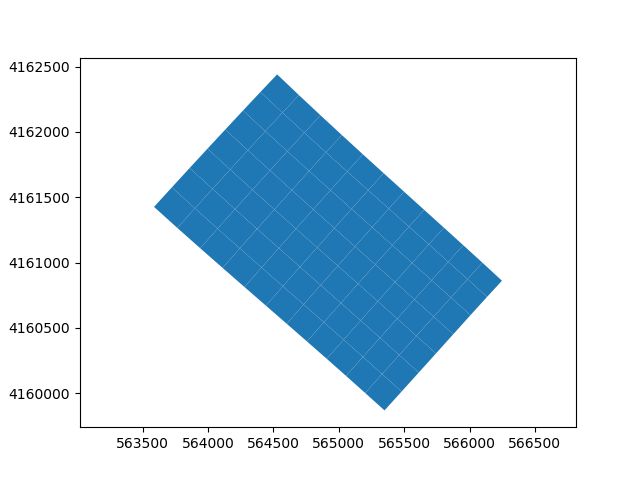

salt loss over 30 days: -0.19040468520505172 per volume -3.1417559347995883 per area


In [20]:
# a closed bit of south bay channel
section=np.array([[ 563586.33844126, 4161411.99518851],
                  [ 565340.1579425 , 4159867.14141507],
                  [ 566258.11453252, 4160844.80249874],
                  [ 564541.61033981, 4162441.89770413],
                  [ 563593.80150297, 4161411.99518851]] )
section=section[::-1,:] 

sec=extract_section(section,extra_vars=['s_F'])

plt.figure()
plt.plot(sec.time,sec.s_F)
plt.plot(sec.time, 
         filters.lowpass(sec.s_F.values,utils.to_dnum(sec.time.values),
                                       cutoff=4))
win=np.hanning(len(sec.time))
win=win/win.sum()

s_F_total=(win*sec.s_F.values).sum()
Q_total=(win*sec.Q.values).sum()
print(f"salt flux total: {s_F_total}   Q total: {Q_total}")

sel_cells=section_to_cells( np.c_[sec.x.values,sec.y.values] )

plt.figure()
g.plot_cells(mask=sel_cells)
plt.axis('equal')

Ac=avg.Ac.values[sel_cells]
dv=avg.dv.values[sel_cells]
eta=avg.eta.isel(time=10).values[sel_cells]
V=((dv+eta)*Ac).sum()
A=Ac.sum()

salt_flux_int=s_F_total * 86400 * 30
print(f"salt loss over 30 days: {salt_flux_int/V} per volume {salt_flux_int/A} per area")

# need to account for change in storage, too.



In [85]:
# a patch of far south bay shoal
section=np.array([[ 572814.33781193, 4167249.95438637],
          [ 573775.04979296, 4168270.71086622],
          [ 574124.39960425, 4166867.85303028],
          [ 573103.6431244 , 4165868.93091363],
          [ 572808.87922112, 4167249.95438637]])

sec=extract_section(section,extra_vars=['s_F'])
if 0:
    plt.figure()
    plt.plot(sec.time,sec.s_F)
    plt.plot(sec.time, 
             filters.lowpass(sec.s_F.values,utils.to_dnum(sec.time.values),
                                           cutoff=4))
win=np.hanning(len(sec.time))
win=win/win.sum()

s_F_total=(win*sec.s_F.values).sum()
Q_total=(win*sec.Q.values).sum()
print(f"salt flux total: {s_F_total}   Q total: {Q_total}")

sel_cells=section_to_cells(np.c_[sec.x.values,sec.y.values])
if 0:
    plt.figure()
    g.plot_cells(mask=sel_cells)
    plt.axis('equal')

Ac=avg.Ac.values[sel_cells]
dv=avg.dv.values[sel_cells]
eta=avg.eta.isel(time=10).values[sel_cells]
V=((dv+eta)*Ac).sum()
A=Ac.sum()

t0=11
tN=len(sec.time)-13 # index of the last state

# change in storage.  just used depth-averaged salinity, since we don't have 
# dzz.
eta0=avg.eta.isel(time=t0).values[sel_cells]
etaN=avg.eta.isel(time=tN).values[sel_cells]

salt_conc0_3d=(avg.salt.isel(time=t0).values[:,sel_cells])
salt_conc0_3d=np.where(salt_conc0_3d==0,np.nan,salt_conc0_3d) # dry layers
salt_conc0_2d=np.nanmean(salt_conc0_3d,axis=0)
vol0s=(eta0+dv)*Ac
salt_mass0=(salt_conc0_2d*vol0s).sum()

salt_concN_3d=(avg.salt.isel(time=tN).values[:,sel_cells])
salt_concN_3d=np.where(salt_concN_3d==0,np.nan,salt_concN_3d) # dry layers
salt_concN_2d=np.nanmean(salt_concN_3d,axis=0)
volNs=(etaN+dv)*Ac
salt_massN=(salt_concN_2d*volNs).sum()

dt_secs=(avg.time.values[tN] - avg.time.values[t0])/np.timedelta64(1,'s')

#salt_flux_int=s_F_total * dt_secs
print(f"salt loss over 30 days: {salt_flux_int/V} per volume {salt_flux_int/A} per area")
print(f"initial: conc {salt_conc0_2d.mean():7.2f}  salt mass {salt_mass0:7.3e}  water {vol0s.sum():7.3e}")
print(f"final:   conc {salt_concN_2d.mean():7.2f}  salt mass {salt_massN:7.3e}  water {volNs.sum():7.3e}")

# this number should be zero.
# salt_flux_int is an estimate of how much salt fluxed "downstream" over
# the time period.
salt_dmass=salt_massN-salt_mass0

dt_s=(avg.time.values[-1] - avg.time.values[-2])/np.timedelta64(1,'s')

# alternative way to calculate this - might have one off here.
stagger=1
salt_flux_tot=(sec.s_F.values[t0+stagger:tN+stagger]*dt_s).sum()

#salt_balance= in - out - accum
salt_balance=0 - salt_flux_tot - (salt_massN-salt_mass0)
print(f"balance ({salt_balance:.3e}) = - flux_out({salt_flux_tot:.3e}) - delta storage({salt_massN-salt_mass0:.3e})")

salt flux total: -2.4163166716784974   Q total: -0.02104521652318528
salt loss over 30 days: -1.4937759716546501 per volume -3.820145573189255 per area
initial: conc   23.05  salt mass 9.399e+07  water 4.078e+06
final:   conc   24.89  salt mass 1.044e+08  water 4.196e+06
balance (1.178e+06) = - flux_out(-1.161e+07) - delta storage(1.043e+07)


In [70]:
t0,tN

(17, 1512)

In [41]:
avg.U_F

<xarray.DataArray 'U_F' (time: 1513, Nk: 60, Ne: 105864)>
[9610333920 values with dtype=float64]
Coordinates:
    xe       (Ne) float64 ...
    ye       (Ne) float64 ...
    z_r      (Nk) float64 ...
  * time     (time) datetime64[ns] 2017-07-01 ... 2017-08-01T12:00:00
Dimensions without coordinates: Nk, Ne
Attributes:
    long_name:  Time-averaged edge flux rate
    units:      m3 s-1
    mesh:       suntans_mesh
    location:   edge

In [45]:
sec.Q

<xarray.DataArray 'Q' (time: 1513)>
array([   0.      ,    0.      , -123.922779, ...,  -46.766726,  -78.93128 ,
       -108.400878])
Coordinates:
  * time     (time) datetime64[ns] 2017-07-01 ... 2017-08-01T12:00:00